# Description

This Notebook is trying to train a dataset of the middle tier of hoursing price in US metro breakdown with Random Forest Regression. We have the location info as States, and the July price of 2021 and 2020. We want to predict the housing price of July 2022

In [1]:
import numpy as np 
import pandas as pd
import pymongo
from pymongo import MongoClient

from sklearn.model_selection import train_test_split
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor
import statistics

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

# Functions we can use later

#from sklearn.metrics import accuracy_score
#import tensorflow as tf
#from sklearn.preprocessing import StandardScaler,OneHotEncoder

# I. Connect the Database

In [2]:
# Connect Mongodb with Jupyter 
# https://gist.github.com/gabefair/a28f77e3899b98f042ac74e17380fe24

client=MongoClient('localhost',27017)

In [3]:
db=client['FinalProject']

In [4]:
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'FinalProject')

In [5]:
allDataconn=db['Metro_Mid_All_updated_final']
allDataCursor=allDataconn.find()
AllData_df=pd.DataFrame(list(allDataCursor))

In [6]:
AllData_df

,_id,RegionID,RegionName,Statename,julyvalue16,julyvalue17,julyvalue18,julyvalue19,julyvalue20,julyvalue21,...,PopMale20,PopFemale20,MedianAge20,MedianAgeMale20,medianAgeFemale20,pop21,PopMale21,PopFemale21,MedianAgeMale21,MedianAgeFemale21
0,6306af830eac8f01d7192653,394297,"Aberdeen, SD",SD,150756,160313,168185,173277,175803,192832,...,20937.0,21250.0,38.3,37.7,39.0,42134.0,20903.0,21231.0,38.0,39.2
1,6306af830eac8f01d7192654,394298,"Aberdeen, WA",WA,143058,155767,174051,192211,217648,274100,...,38877.0,36934.0,44.4,43.2,45.8,76841.0,39448.0,37393.0,43.5,45.9
2,6306af830eac8f01d7192655,394299,"Abilene, TX",TX,119201,123626,131428,136147,141065,158980,...,89408.0,87401.0,34.2,33.2,35.2,177314.0,89671.0,87643.0,33.5,35.3
3,6306af830eac8f01d7192656,394300,"Ada, OK",OK,94179,96676,103013,99878,104325,116926,...,18620.0,19457.0,35.9,34.9,37.0,38163.0,18561.0,19602.0,35.0,36.9
4,6306af830eac8f01d7192657,394302,"Adrian, MI",MI,132336,145224,151872,159528,165701,189462,...,50413.0,48801.0,41.9,40.5,43.6,98956.0,50297.0,48659.0,40.8,43.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,6306af840eac8f01d71929d9,753925,"Vineyard Haven, MA",MA,724302,770010,807091,840047,860818,991822,...,10173.0,10408.0,48.8,47.5,50.0,21097.0,10397.0,10700.0,47.7,50.0
903,6306af840eac8f01d71929da,753926,"Weatherford, OK",OK,118489,112530,113738,114721,118732,128883,...,14241.0,14182.0,31.6,30.9,32.3,28163.0,14064.0,14099.0,30.7,32.6
904,6306af840eac8f01d71929db,753927,"Winnemucca, NV",NV,207449,219834,242939,248047,247928,271344,...,9025.0,8258.0,36.2,36.6,35.7,17648.0,9167.0,8481.0,36.7,35.6
905,6306af840eac8f01d71929dc,753928,"Wisconsin Rapids-Marshfield, WI",WI,107686,113290,120168,126189,128885,150185,...,36871.0,37220.0,43.6,42.4,44.9,74070.0,36855.0,37215.0,42.5,44.9


In [7]:
AllData_df.nunique()

_id                  907
RegionID             907
RegionName           907
Statename             51
julyvalue16          882
julyvalue17          881
julyvalue18          890
julyvalue19          898
julyvalue20          895
julyvalue21          900
Janvalue22           903
febvalue22           902
marchvalue22         904
aprvalue22           905
mayvalue22           905
junevalue22          906
julyvalue22          907
JulyListings22       427
JulyInv22            546
pop20                887
PopMale20            887
PopFemale20          885
MedianAge20          220
MedianAgeMale20      204
medianAgeFemale20    221
pop21                886
PopMale21            888
PopFemale21          884
MedianAgeMale21      210
MedianAgeFemale21    229
dtype: int64

# II. Process the Data

In [8]:
merge_df=AllData_df.drop(columns=['_id'])
merge_df=merge_df.dropna(how='any')
print(merge_df.shape)
merge_df.head()

(884, 29)


,RegionID,RegionName,Statename,julyvalue16,julyvalue17,julyvalue18,julyvalue19,julyvalue20,julyvalue21,Janvalue22,...,PopMale20,PopFemale20,MedianAge20,MedianAgeMale20,medianAgeFemale20,pop21,PopMale21,PopFemale21,MedianAgeMale21,MedianAgeFemale21
0,394297,"Aberdeen, SD",SD,150756,160313,168185,173277,175803,192832,202526,...,20937.0,21250.0,38.3,37.7,39.0,42134.0,20903.0,21231.0,38.0,39.2
1,394298,"Aberdeen, WA",WA,143058,155767,174051,192211,217648,274100,318556,...,38877.0,36934.0,44.4,43.2,45.8,76841.0,39448.0,37393.0,43.5,45.9
2,394299,"Abilene, TX",TX,119201,123626,131428,136147,141065,158980,172185,...,89408.0,87401.0,34.2,33.2,35.2,177314.0,89671.0,87643.0,33.5,35.3
3,394300,"Ada, OK",OK,94179,96676,103013,99878,104325,116926,127384,...,18620.0,19457.0,35.9,34.9,37.0,38163.0,18561.0,19602.0,35.0,36.9
4,394302,"Adrian, MI",MI,132336,145224,151872,159528,165701,189462,210403,...,50413.0,48801.0,41.9,40.5,43.6,98956.0,50297.0,48659.0,40.8,43.7


In [9]:
merge_df.dtypes

RegionID               int64
RegionName            object
Statename             object
julyvalue16            int64
julyvalue17            int64
julyvalue18            int64
julyvalue19            int64
julyvalue20            int64
julyvalue21            int64
Janvalue22             int64
febvalue22             int64
marchvalue22           int64
aprvalue22             int64
mayvalue22             int64
junevalue22            int64
julyvalue22            int64
JulyListings22       float64
JulyInv22              int64
pop20                float64
PopMale20            float64
PopFemale20          float64
MedianAge20          float64
MedianAgeMale20      float64
medianAgeFemale20    float64
pop21                float64
PopMale21            float64
PopFemale21          float64
MedianAgeMale21      float64
MedianAgeFemale21    float64
dtype: object

### 1. Change the datatypes and add more feature columns

In [10]:
MedianAge21=(merge_df['MedianAgeMale21']+ merge_df['MedianAgeFemale21'])/2
merge_df['MedianAge21']=MedianAge21

#Format the value to have fewer unique numbers for future grouping
merge_df['MedianAge21'] = merge_df['MedianAge21'].map("{:.1f}".format).astype(float)
merge_df

,RegionID,RegionName,Statename,julyvalue16,julyvalue17,julyvalue18,julyvalue19,julyvalue20,julyvalue21,Janvalue22,...,PopFemale20,MedianAge20,MedianAgeMale20,medianAgeFemale20,pop21,PopMale21,PopFemale21,MedianAgeMale21,MedianAgeFemale21,MedianAge21
0,394297,"Aberdeen, SD",SD,150756,160313,168185,173277,175803,192832,202526,...,21250.0,38.3,37.7,39.0,42134.0,20903.0,21231.0,38.0,39.2,38.6
1,394298,"Aberdeen, WA",WA,143058,155767,174051,192211,217648,274100,318556,...,36934.0,44.4,43.2,45.8,76841.0,39448.0,37393.0,43.5,45.9,44.7
2,394299,"Abilene, TX",TX,119201,123626,131428,136147,141065,158980,172185,...,87401.0,34.2,33.2,35.2,177314.0,89671.0,87643.0,33.5,35.3,34.4
3,394300,"Ada, OK",OK,94179,96676,103013,99878,104325,116926,127384,...,19457.0,35.9,34.9,37.0,38163.0,18561.0,19602.0,35.0,36.9,36.0
4,394302,"Adrian, MI",MI,132336,145224,151872,159528,165701,189462,210403,...,48801.0,41.9,40.5,43.6,98956.0,50297.0,48659.0,40.8,43.7,42.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,753925,"Vineyard Haven, MA",MA,724302,770010,807091,840047,860818,991822,1079642,...,10408.0,48.8,47.5,50.0,21097.0,10397.0,10700.0,47.7,50.0,48.9
903,753926,"Weatherford, OK",OK,118489,112530,113738,114721,118732,128883,138100,...,14182.0,31.6,30.9,32.3,28163.0,14064.0,14099.0,30.7,32.6,31.6
904,753927,"Winnemucca, NV",NV,207449,219834,242939,248047,247928,271344,291286,...,8258.0,36.2,36.6,35.7,17648.0,9167.0,8481.0,36.7,35.6,36.2
905,753928,"Wisconsin Rapids-Marshfield, WI",WI,107686,113290,120168,126189,128885,150185,162435,...,37220.0,43.6,42.4,44.9,74070.0,36855.0,37215.0,42.5,44.9,43.7


In [11]:
# allnewListing_df = pd.read_csv("../Resources/Metro_new_listings_uc_sfrcondo_sm_month.csv")
# print(allnewListing_df.shape)
# allnewListing_df.head()

In [12]:
# july22NewListing=allnewListing_df[['RegionID','2022-07-31']]
# july22NewListing.rename(columns={'2022-07-31': 'July22NewListingNo.'}, inplace = True)

# july22NewListing.head()

In [13]:
# allInventory_df=pd.read_csv("../Resources/Metro_invt_fs_uc_sfrcondo_sm_month.csv")

# print(allInventory_df.shape)
# allInventory_df.head()

In [14]:
# julyInventory=allInventory_df[['RegionID','2022-07-31']]
# julyInventory.rename(columns={'2022-07-31': 'July22Inventory'}, inplace = True)

# julyInventory.head()

In [15]:
## Join the new listing and inventory of July df

In [16]:
# julyhome=july22NewListing.merge(julyInventory, on='RegionID', how='left')
# julyhome.dropna()
# julyhome

In [17]:
# julyhome.dtypes

### 2. Change the Category column of `Statename` to numbers.

In [18]:
#numbers=[*range(1,52,1)] 
# dict={states[i]: numbers[i] for i in range(len(states))}

states=merge_df["Statename"].unique().tolist()

dict={states[i]: i for i in range(len(states))} 

dict

{'SD': 0,
 'WA': 1,
 'TX': 2,
 'OK': 3,
 'MI': 4,
 'OH': 5,
 'NM': 6,
 'GA': 7,
 'OR': 8,
 'NY': 9,
 'MN': 10,
 'AL': 11,
 'LA': 12,
 'PA': 13,
 'IA': 14,
 'AK': 15,
 'IN': 16,
 'WI': 17,
 'FL': 18,
 'AR': 19,
 'NC': 20,
 'KS': 21,
 'TN': 22,
 'NJ': 23,
 'ME': 24,
 'CA': 25,
 'MD': 26,
 'MA': 27,
 'VT': 28,
 'NE': 29,
 'WV': 30,
 'SC': 31,
 'NH': 32,
 'MT': 33,
 'ND': 34,
 'ID': 35,
 'VA': 36,
 'CO': 37,
 'KY': 38,
 'MO': 39,
 'CT': 40,
 'MS': 41,
 'IL': 42,
 'NV': 43,
 'WY': 44,
 'UT': 45,
 'DE': 46,
 'AZ': 47,
 'HI': 48,
 'RI': 49,
 'DC': 50}

In [19]:
# merge_df=month_df.merge(julyhome, on='RegionID', how='left')
merge_df['StateCode']=merge_df['Statename'].map(dict)
merge_df=merge_df.dropna()
merge_df

,RegionID,RegionName,Statename,julyvalue16,julyvalue17,julyvalue18,julyvalue19,julyvalue20,julyvalue21,Janvalue22,...,MedianAge20,MedianAgeMale20,medianAgeFemale20,pop21,PopMale21,PopFemale21,MedianAgeMale21,MedianAgeFemale21,MedianAge21,StateCode
0,394297,"Aberdeen, SD",SD,150756,160313,168185,173277,175803,192832,202526,...,38.3,37.7,39.0,42134.0,20903.0,21231.0,38.0,39.2,38.6,0
1,394298,"Aberdeen, WA",WA,143058,155767,174051,192211,217648,274100,318556,...,44.4,43.2,45.8,76841.0,39448.0,37393.0,43.5,45.9,44.7,1
2,394299,"Abilene, TX",TX,119201,123626,131428,136147,141065,158980,172185,...,34.2,33.2,35.2,177314.0,89671.0,87643.0,33.5,35.3,34.4,2
3,394300,"Ada, OK",OK,94179,96676,103013,99878,104325,116926,127384,...,35.9,34.9,37.0,38163.0,18561.0,19602.0,35.0,36.9,36.0,3
4,394302,"Adrian, MI",MI,132336,145224,151872,159528,165701,189462,210403,...,41.9,40.5,43.6,98956.0,50297.0,48659.0,40.8,43.7,42.2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,753925,"Vineyard Haven, MA",MA,724302,770010,807091,840047,860818,991822,1079642,...,48.8,47.5,50.0,21097.0,10397.0,10700.0,47.7,50.0,48.9,27
903,753926,"Weatherford, OK",OK,118489,112530,113738,114721,118732,128883,138100,...,31.6,30.9,32.3,28163.0,14064.0,14099.0,30.7,32.6,31.6,3
904,753927,"Winnemucca, NV",NV,207449,219834,242939,248047,247928,271344,291286,...,36.2,36.6,35.7,17648.0,9167.0,8481.0,36.7,35.6,36.2,43
905,753928,"Wisconsin Rapids-Marshfield, WI",WI,107686,113290,120168,126189,128885,150185,162435,...,43.6,42.4,44.9,74070.0,36855.0,37215.0,42.5,44.9,43.7,17


In [20]:
merge_df.nunique()

RegionID             884
RegionName           884
Statename             51
julyvalue16          862
julyvalue17          860
julyvalue18          869
julyvalue19          875
julyvalue20          872
julyvalue21          877
Janvalue22           880
febvalue22           879
marchvalue22         881
aprvalue22           882
mayvalue22           882
junevalue22          883
julyvalue22          884
JulyListings22       425
JulyInv22            539
pop20                882
PopMale20            882
PopFemale20          880
MedianAge20          220
MedianAgeMale20      203
medianAgeFemale20    221
pop21                881
PopMale21            883
PopFemale21          879
MedianAgeMale21      210
MedianAgeFemale21    229
MedianAge21          210
StateCode             51
dtype: int64

In [21]:
merge_df.dtypes

RegionID               int64
RegionName            object
Statename             object
julyvalue16            int64
julyvalue17            int64
julyvalue18            int64
julyvalue19            int64
julyvalue20            int64
julyvalue21            int64
Janvalue22             int64
febvalue22             int64
marchvalue22           int64
aprvalue22             int64
mayvalue22             int64
junevalue22            int64
julyvalue22            int64
JulyListings22       float64
JulyInv22              int64
pop20                float64
PopMale20            float64
PopFemale20          float64
MedianAge20          float64
MedianAgeMale20      float64
medianAgeFemale20    float64
pop21                float64
PopMale21            float64
PopFemale21          float64
MedianAgeMale21      float64
MedianAgeFemale21    float64
MedianAge21          float64
StateCode              int64
dtype: object

In [22]:
#  merge_df['July22NewListingNo.'] = merge_df['July22NewListingNo.'].fillna(0)
#  merge_df['July22Inventory'] = merge_df['July22Inventory'].fillna(0)

# merge_df['July22NewListingNo.'] = merge_df['July22NewListingNo.'].astype(int)
# merge_df['July22Inventory'] = merge_df['July22Inventory'].astype(int)
# merge_df.dtypes

In [23]:
merge_df.to_csv('merged_data_mongodb.csv')

# III. Random Forest Model Training

## 1st training: 
### Statecode+2 previous years' July Data

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X, y = merge_df[['StateCode','julyvalue20','julyvalue21']], merge_df['julyvalue22']

In [77]:
# Only Tran the model
rf = RandomForestRegressor(n_estimators=100) 
rf.fit(X, y)

predictions = rf.predict(X)
e = mean_absolute_error(y, predictions)
ep = e*100.0/y.mean()
print(f"${e:.0f} average error; {ep:.2f}% error")

$4666 average error; 1.74% error


In [80]:
# Train and Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


validation_e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")


$12112 average error; 4.52% error


In [81]:
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,
                           oob_score=True)   # get error estimate
rf.fit(X_train, y_train)
noisy_oob_r2 = rf.oob_score_
print(f"OOB score {noisy_oob_r2:.4f}")

OOB score 0.9813


##### Importance

In [82]:
from rfpimp import *
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
julyvalue21,1.186503
julyvalue20,0.119361
StateCode,0.004442


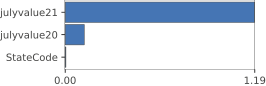

In [83]:
plot_importances(I, color='#4575b4', vscale=1.8)

## 2nd training: 
### Statecode+2 previous years' July Data + 3 most recent month

In [84]:
X, y = merge_df[['StateCode','julyvalue20','julyvalue21','aprvalue22','mayvalue22','junevalue22']], merge_df['julyvalue22']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


validation_e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")


$2583 average error; 0.96% error


In [90]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
junevalue22,0.716843
mayvalue22,0.098356
aprvalue22,0.042859
julyvalue21,0.000527
StateCode,-0.000032
julyvalue20,-0.000402


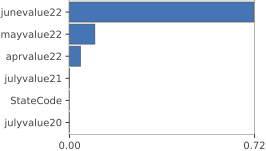

In [91]:
plot_importances(I, color='#4575b4', vscale=1.8)

## 3rd training
### Every Feature (2021 population of total and different sex, homevalues, statecode, inventory and new listing homes)

In [93]:
y=merge_df['julyvalue22']
X=merge_df.drop(columns=['julyvalue22', 'RegionName','Statename', 'RegionID'])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


validation_e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")

$3548 average error; 1.32% error


In [98]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
junevalue22,0.850551
mayvalue22,0.067478
aprvalue22,0.013380
marchvalue22,0.007136
Janvalue22,0.005433
julyvalue19,0.004363
febvalue22,0.002745
julyvalue20,0.002040
julyvalue21,0.001579


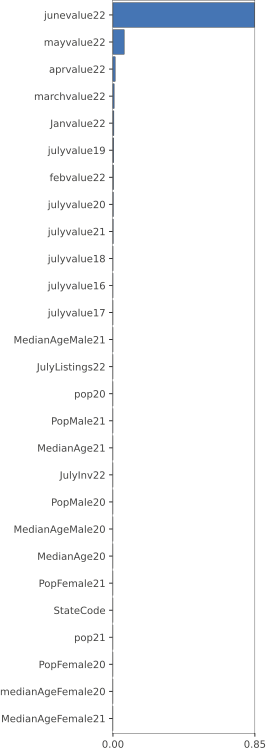

In [99]:
plot_importances(I, color='#4575b4', vscale=1.8)

## 4th Try Statecode+ 3 most recent month

In [100]:
X, y = merge_df[['StateCode','marchvalue22','aprvalue22','mayvalue22','junevalue22']], merge_df['julyvalue22']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

y_predict=rf.predict(X_test)

validation_e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")

$1813 average error; 0.68% error


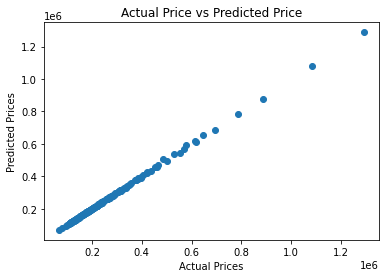

In [103]:
plt.scatter(y_test, y_predict)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Price vs Predicted Price')
plt.show()

In [104]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
I

,Importance
Feature,
junevalue22,0.743542
mayvalue22,0.061179
aprvalue22,0.036399
marchvalue22,0.019746
StateCode,0.000002


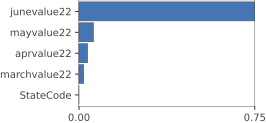

In [105]:
plot_importances(I, color='#4575b4', vscale=1.8)

# Find the baseline

In [106]:
df=merge_df[['aprvalue22','mayvalue22','junevalue22','julyvalue22']]
df.std(axis=1).describe()

count      884.000000
mean      3741.840057
std       3606.107448
min        192.109995
25%       1724.927403
50%       2695.403591
75%       4551.294637
max      35343.664877
dtype: float64

In [112]:
# The Standard Deviation of each Metro Area between these specific months 
# (months features that bring the highest score)

std_row=df.std(axis=1)
stdRow_df=pd.DataFrame(std_row, columns=['StandardDeviation'])
stdRow_df['StandardDeviation'] = stdRow_df['StandardDeviation'].astype(float)
stdRow_df

,StandardDeviation
0,2403.018570
1,8152.382448
2,2364.144437
3,1471.527324
4,4142.236192
...,...
902,11552.508328
903,1258.109826
904,2753.963129
905,2166.508328


<AxesSubplot:>

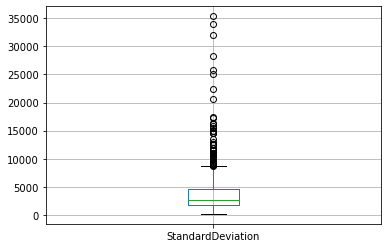

In [113]:
stdRow_df.boxplot(column=['StandardDeviation'])

In [43]:
df2=merge_df[[julyvalue22', julyvalue22', 'aprvalue22','mayvalue22','junevalue22','julyvalue22']]

# Get the Standandard Deviation of each row (STD of different months for each metro area)
df2.std(axis=1).describe()

28783.288574912447

In [76]:
std_row2=df2.std(axis=1)
stdRow_df2=pd.DataFrame(std_row2, columns=['StandardDeviation'])
stdRow_df2['StandardDeviation'] = stdRow_df2['StandardDeviation'].astype(float)
stdRow_df2.head()

,StandardDeviation
0,50530.867804
1,101868.242582
2,27199.354277
3,55454.699814
4,30865.254371


<AxesSubplot:>

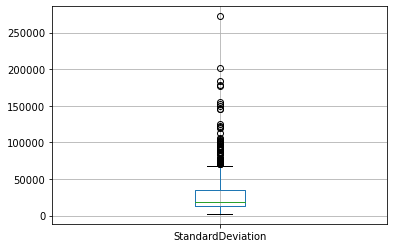

In [77]:
stdRow_df2.boxplot(column=['StandardDeviation'])

# Visualization

/Users/bibowang/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


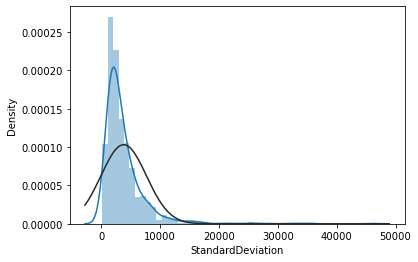

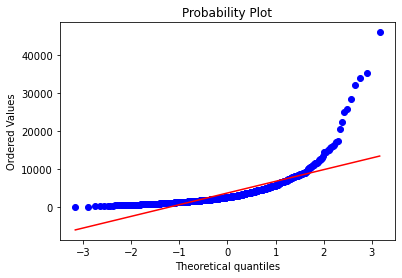

In [78]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm

sns.distplot(stdRow_df['StandardDeviation'], fit=norm);
fig = plt.figure()
res = stats.probplot(stdRow_df['StandardDeviation'], plot=plt)

In [80]:
july2022 = merge_df['7/31/22']
avg_price=july2022.mean()
print(f'Average housing price in the United States is ${avg_price}')

Average housing price in the United States is $267978.93265993265


In [81]:
bystate=merge_df.groupby(['StateName']).mean()
bystate=bystate.reset_index()
bystate.head()

,StateName,RegionID,7/31/20,7/31/21,4/30/22,5/31/22,6/30/22,7/31/22,July22NewListingNo.,July22Inventory,StateCode
0,AK,394595.000000,303952.750000,321684.750000,338684.750000,340723.500000,344610.000000,347937.250000,223.750000,430.250000,42.0
1,AL,411830.333333,138220.666667,156691.857143,178346.809524,180160.952381,182167.904762,183862.952381,290.380952,647.809524,29.0
2,AR,412656.200000,107795.200000,120754.850000,137123.650000,138383.900000,139730.950000,140997.300000,159.000000,380.500000,35.0
3,AZ,394988.727273,242869.454545,307062.272727,366843.363636,373343.909091,378175.454545,380385.363636,1208.454545,2791.545455,10.0
4,CA,416672.181818,463558.424242,558103.363636,632188.696970,638838.272727,641765.757576,640983.212121,1119.424242,2360.606061,1.0


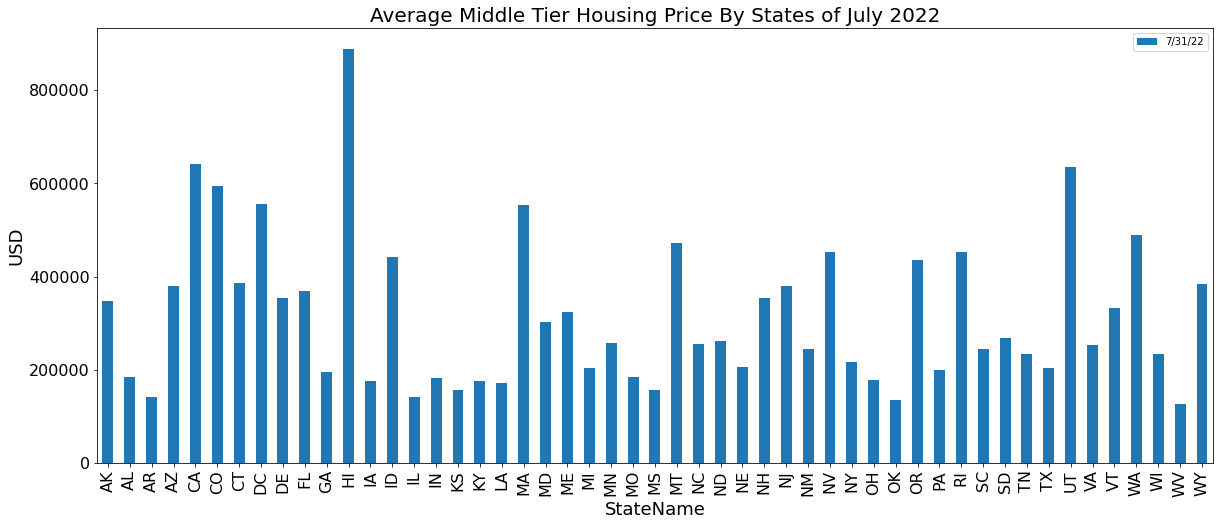

In [83]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# bystate.plot(kind="bar", color="red")
bystate.plot.bar('StateName','7/31/22', style='-o')
plt.xlabel('StateName', size=18)
plt.ylabel('USD', size=18)
plt.xticks(rotation=90,size=16)
plt.yticks(size=16)
plt.title("Average Middle Tier Housing Price By States of July 2022", size=20)
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

/Users/bibowang/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


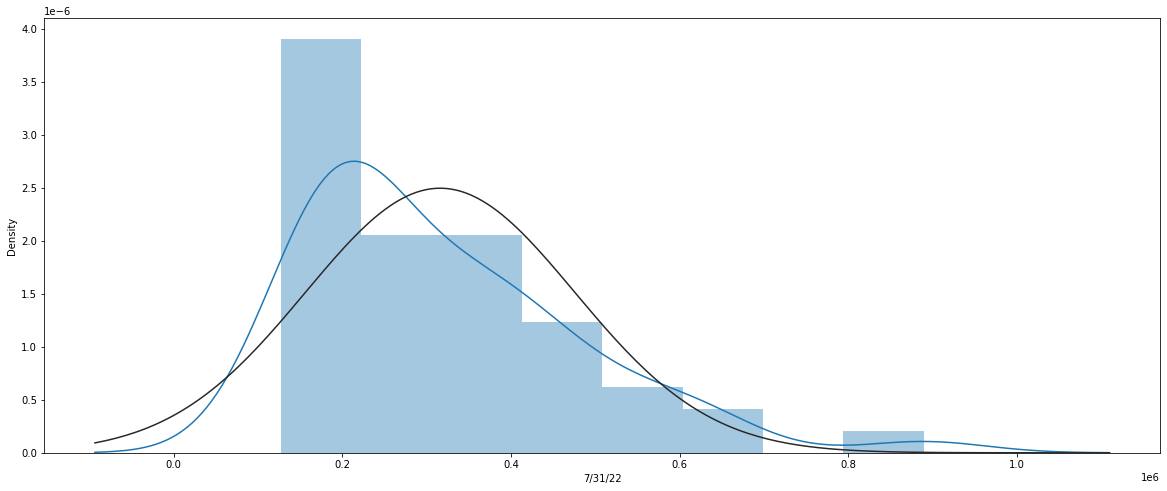

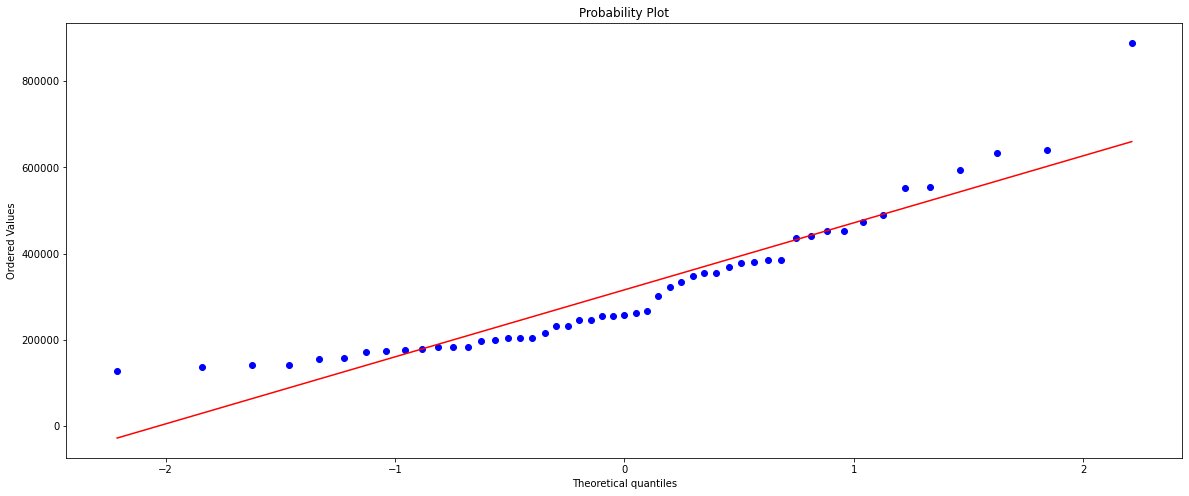

In [84]:
sns.distplot(bystate['7/31/22'], fit=norm);
fig = plt.figure()
res = stats.probplot(bystate['7/31/22'], plot=plt)